# MomentsLD Parameter Analysis: Best Fit vs Ground Truth

This notebook analyzes the MomentsLD optimization results from split migration experiments, comparing best fit parameters against ground truth values and visualizing parameter distributions across replicates. MomentsLD uses linkage disequilibrium (LD) statistics for demographic inference.

## Import Required Libraries

Import necessary libraries for data manipulation and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from pathlib import Path
import glob
from scipy import stats

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Set Up Data Paths

Define paths to the experiment directories containing simulations and MomentsLD results.

In [2]:
# Define base paths
base_path = Path('/home/akapoor/kernlab/Infer_Demography/experiments/split_isolation/')
simulations_path = base_path / 'simulations'
inferences_path = base_path / 'inferences'

print(f"Base path: {base_path}")
print(f"Simulations path: {simulations_path}")
print(f"Inferences path: {inferences_path}")

# Check if paths exist
print(f"\nPaths exist:")
print(f"Simulations: {simulations_path.exists()}")
print(f"Inferences: {inferences_path.exists()}")

# Check MomentsLD results structure
momentsld_dirs = list(inferences_path.glob('sim_*/MomentsLD'))
print(f"\nFound {len(momentsld_dirs)} MomentsLD result directories")
if momentsld_dirs:
    print(f"Example: {momentsld_dirs[0]}")
    # List files in first MomentsLD directory
    example_files = list(momentsld_dirs[0].glob('*'))
    print(f"Files in MomentsLD directory:")
    for f in example_files[:10]:  # Show first 10 files
        print(f"  {f.name}")

Base path: /home/akapoor/kernlab/Infer_Demography/experiments/split_isolation
Simulations path: /home/akapoor/kernlab/Infer_Demography/experiments/split_isolation/simulations
Inferences path: /home/akapoor/kernlab/Infer_Demography/experiments/split_isolation/inferences

Paths exist:
Simulations: True
Inferences: True

Found 5000 MomentsLD result directories
Example: /home/akapoor/kernlab/Infer_Demography/experiments/split_isolation/inferences/sim_879/MomentsLD
Files in MomentsLD directory:
  windows
  LD_stats


## Load Ground Truth Parameters

Load the true parameter values used for each simulation replicate.

In [3]:
def load_ground_truth_params(sim_dir):
    """Load ground truth parameters from a simulation directory."""
    sampled_params_file = sim_dir / 'sampled_params.pkl'
    if sampled_params_file.exists():
        with open(sampled_params_file, 'rb') as f:
            return pickle.load(f)
    return None

# Load ground truth parameters for all simulations
ground_truth_data = []
# Look for numbered directories (0, 1, 2, ...) not sim_* pattern
sim_dirs = sorted([d for d in simulations_path.iterdir() if d.is_dir() and d.name.isdigit()])

print(f"Loading ground truth parameters from {len(sim_dirs)} simulations...")

for sim_dir in sim_dirs:
    sim_id = int(sim_dir.name)  # Directory name is just the number
    params = load_ground_truth_params(sim_dir)
    
    if params is not None:
        params['sim_id'] = sim_id
        ground_truth_data.append(params)
        if sim_id == 0:  # Debug: show what's in the first simulation
            print(f"DEBUG: Simulation 0 ground truth parameters: {params}")

# Convert to DataFrame
gt_df = pd.DataFrame(ground_truth_data)
print(f"\nLoaded ground truth for {len(gt_df)} simulations")
if not gt_df.empty:
    print("\nGround truth parameter summary:")
    print(gt_df.describe())
else:
    print("ERROR: No ground truth data loaded!")

Loading ground truth parameters from 5000 simulations...
DEBUG: Simulation 0 ground truth parameters: {'N_anc': 23241.285851823304, 'N_YRI': 13222.465348586364, 'N_CEU': 25772.077805350335, 'm_YRI_CEU': 6.97398292256458e-05, 'T_split': 2336.4582838091656, 'sim_id': 0}

Loaded ground truth for 5000 simulations

Ground truth parameter summary:
              N_anc         N_YRI         N_CEU     m_YRI_CEU       T_split  \
count   5000.000000   5000.000000   5000.000000  5.000000e+03   5000.000000   
mean   14997.108548  15151.320564  15284.826915  4.908407e-05  10381.007506   
std     8572.732606   8615.401240   8561.354110  2.877914e-05   5621.247347   
min      115.746698    115.238032    110.835215  3.458968e-08    504.614668   
25%     7557.689362   7796.809596   8022.696496  2.405610e-05   5519.740015   
50%    15018.309584  15126.097063  15303.126932  4.929707e-05  10408.562009   
75%    22280.668348  22718.007843  22838.047720  7.319771e-05  15252.296627   
max    29997.925155  299

## Load MomentsLD Best Fit Results

Load the best fit parameters from MomentsLD optimization for each simulation.

In [4]:
def load_momentsld_results(momentsld_dir):
    """Load MomentsLD best fit results from a MomentsLD directory."""
    best_fit_file = momentsld_dir / 'best_fit.pkl'
    if best_fit_file.exists():
        with open(best_fit_file, 'rb') as f:
            return pickle.load(f)
    return None

# Load MomentsLD results for all simulations
momentsld_data = []

print(f"Loading MomentsLD results from {len(momentsld_dirs)} directories...")

for momentsld_dir in sorted(momentsld_dirs):
    # Extract sim_id from path
    sim_id = int(momentsld_dir.parent.name.split('_')[1])
    results = load_momentsld_results(momentsld_dir)
    
    if results is not None:
        # Extract best fit parameters
        best_params = results.get('best_params', {})
        # Note: key is 'best_lls' not 'best_ll'
        best_ll = results.get('best_lls', np.nan)
        
        # Add simulation metadata
        result_entry = best_params.copy()
        result_entry['sim_id'] = sim_id
        result_entry['log_likelihood'] = best_ll
        
        momentsld_data.append(result_entry)

# Convert to DataFrame
momentsld_df = pd.DataFrame(momentsld_data)
print(f"\nLoaded MomentsLD results for {len(momentsld_df)} simulations")

if not momentsld_df.empty:
    print("\nMomentsLD parameter summary:")
    # Show numeric columns only
    numeric_cols = momentsld_df.select_dtypes(include=[np.number]).columns
    print(momentsld_df[numeric_cols].describe())
else:
    print("No MomentsLD results found!")

Loading MomentsLD results from 5000 directories...

Loaded MomentsLD results for 310 simulations

MomentsLD parameter summary:
              N_anc         N_YRI         N_CEU     m_YRI_CEU       T_split  \
count    310.000000    310.000000    310.000000  3.100000e+02    310.000000   
mean   16471.792283  15673.443809  15572.906762  5.018120e-05  10387.780462   
std     8546.670290   8242.753326   8772.281686  2.917881e-05   5407.296349   
min      281.864418    146.464122    153.437667  1.000000e-08    500.000000   
25%     9274.062134   9077.035359   8164.107307  2.561086e-05   5580.001572   
50%    17331.829700  16129.046889  15748.887531  5.436423e-05  10847.830591   
75%    23541.737481  22334.231460  23237.614226  7.211961e-05  15193.551151   
max    29910.760740  30000.000000  30000.000000  1.000000e-04  19952.904343   

           sim_id  log_likelihood  
count  310.000000      310.000000  
mean   154.535484     -104.415818  
std     89.697029      333.575021  
min      0.000000

## Merge Ground Truth and MomentsLD Results

Combine the ground truth and best fit parameters for comparison analysis.

In [5]:
# Merge ground truth and MomentsLD results
if not gt_df.empty and not momentsld_df.empty:
    # Merge on sim_id
    merged_df = pd.merge(gt_df, momentsld_df, on='sim_id', suffixes=('_true', '_momentsld'))
    
    print(f"Successfully merged data for {len(merged_df)} simulations")
    print(f"\nColumns in merged dataset:")
    for col in merged_df.columns:
        print(f"  {col}")
        
    # Display first few rows
    print(f"\nFirst 5 rows of merged data:")
    print(merged_df.head())
else:
    print("Cannot merge - missing ground truth or MomentsLD data")
    merged_df = pd.DataFrame()

Successfully merged data for 310 simulations

Columns in merged dataset:
  N_anc_true
  N_YRI_true
  N_CEU_true
  m_YRI_CEU_true
  T_split_true
  sim_id
  N_anc_momentsld
  N_YRI_momentsld
  N_CEU_momentsld
  m_YRI_CEU_momentsld
  T_split_momentsld
  log_likelihood

First 5 rows of merged data:
     N_anc_true    N_YRI_true    N_CEU_true  m_YRI_CEU_true  T_split_true  \
0  23241.285852  13222.465349  25772.077805    6.973983e-05   2336.458284   
1  19603.747955   1408.882177    698.884648    8.392287e-05  11949.289428   
2  18511.312349  17269.366239  15634.353018    6.488903e-07  11230.701655   
3    766.472963   3313.985160  19470.148920    9.607021e-05  15520.834777   
4  12458.272777  29306.083805  15219.049629    6.543318e-05  14301.680407   

   sim_id  N_anc_momentsld  N_YRI_momentsld  N_CEU_momentsld  \
0       0     23317.118829     13276.267925     25908.591836   
1       1     20180.626155      1443.411809       718.719957   
2      10     18390.749809     17302.207002     1

## Parameter Comparison Analysis

Compare the inferred parameters with ground truth values.

In [6]:
if not merged_df.empty:
    # Define parameter pairs for comparison
    param_pairs = []
    
    # Find matching parameter names
    for col in merged_df.columns:
        if col.endswith('_true'):
            param_name = col.replace('_true', '')
            momentsld_col = param_name + '_momentsld'
            if momentsld_col in merged_df.columns:
                param_pairs.append((param_name, col, momentsld_col))
    
    print(f"Found {len(param_pairs)} parameter pairs for comparison:")
    for param_name, true_col, fit_col in param_pairs:
        print(f"  {param_name}: {true_col} vs {fit_col}")
    
    # Calculate relative errors
    comparison_data = []
    
    for param_name, true_col, fit_col in param_pairs:
        for idx, row in merged_df.iterrows():
            true_val = row[true_col]
            fit_val = row[fit_col]
            
            if pd.notna(true_val) and pd.notna(fit_val) and true_val != 0:
                rel_error = (fit_val - true_val) / true_val
                abs_rel_error = abs(rel_error)
                
                comparison_data.append({
                    'sim_id': row['sim_id'],
                    'parameter': param_name,
                    'true_value': true_val,
                    'fitted_value': fit_val,
                    'relative_error': rel_error,
                    'abs_relative_error': abs_rel_error,
                    'log_likelihood': row.get('log_likelihood', np.nan)
                })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(f"\nCreated comparison dataset with {len(comparison_df)} parameter comparisons")
    
    if not comparison_df.empty:
        print("\nRelative error summary by parameter:")
        error_summary = comparison_df.groupby('parameter')['relative_error'].agg([
            'count', 'mean', 'std', 'median', 
            lambda x: np.percentile(x, 25), 
            lambda x: np.percentile(x, 75)
        ]).round(4)
        error_summary.columns = ['count', 'mean', 'std', 'median', 'q25', 'q75']
        print(error_summary)
else:
    print("No data available for parameter comparison")
    comparison_df = pd.DataFrame()

Found 5 parameter pairs for comparison:
  N_anc: N_anc_true vs N_anc_momentsld
  N_YRI: N_YRI_true vs N_YRI_momentsld
  N_CEU: N_CEU_true vs N_CEU_momentsld
  m_YRI_CEU: m_YRI_CEU_true vs m_YRI_CEU_momentsld
  T_split: T_split_true vs T_split_momentsld

Created comparison dataset with 1550 parameter comparisons

Relative error summary by parameter:
           count    mean     std  median     q25     q75
parameter                                               
N_CEU        310 -0.0048  0.0819  0.0024 -0.0013  0.0074
N_YRI        310  0.0002  0.0468  0.0038 -0.0008  0.0086
N_anc        310 -0.0069  0.0583 -0.0030 -0.0079  0.0017
T_split      310 -0.0077  0.0962  0.0007 -0.0073  0.0114
m_YRI_CEU    310  0.0291  0.5844 -0.0033 -0.0163  0.0079


In [7]:
comparison_df

,sim_id,parameter,true_value,fitted_value,relative_error,abs_relative_error,log_likelihood
0,0.0,N_anc,23241.285852,23317.118829,0.003263,0.003263,-68.405676
1,1.0,N_anc,19603.747955,20180.626155,0.029427,0.029427,-59.841306
2,10.0,N_anc,18511.312349,18390.749809,-0.006513,0.006513,-79.464105
3,100.0,N_anc,766.472963,819.470639,0.069145,0.069145,-65.904956
4,101.0,N_anc,12458.272777,12381.171900,-0.006189,0.006189,-99.141385
...,...,...,...,...,...,...,...
1545,95.0,T_split,9614.229334,9540.544779,-0.007664,0.007664,-72.693695
1546,96.0,T_split,17340.103535,17429.093175,0.005132,0.005132,-50.605489
1547,97.0,T_split,19020.737234,18983.205121,-0.001973,0.001973,-111.891982
1548,98.0,T_split,12304.416375,12289.832206,-0.001185,0.001185,-82.363931


## Visualize Parameter Accuracy

Create plots to visualize how well MomentsLD recovers the true parameters.

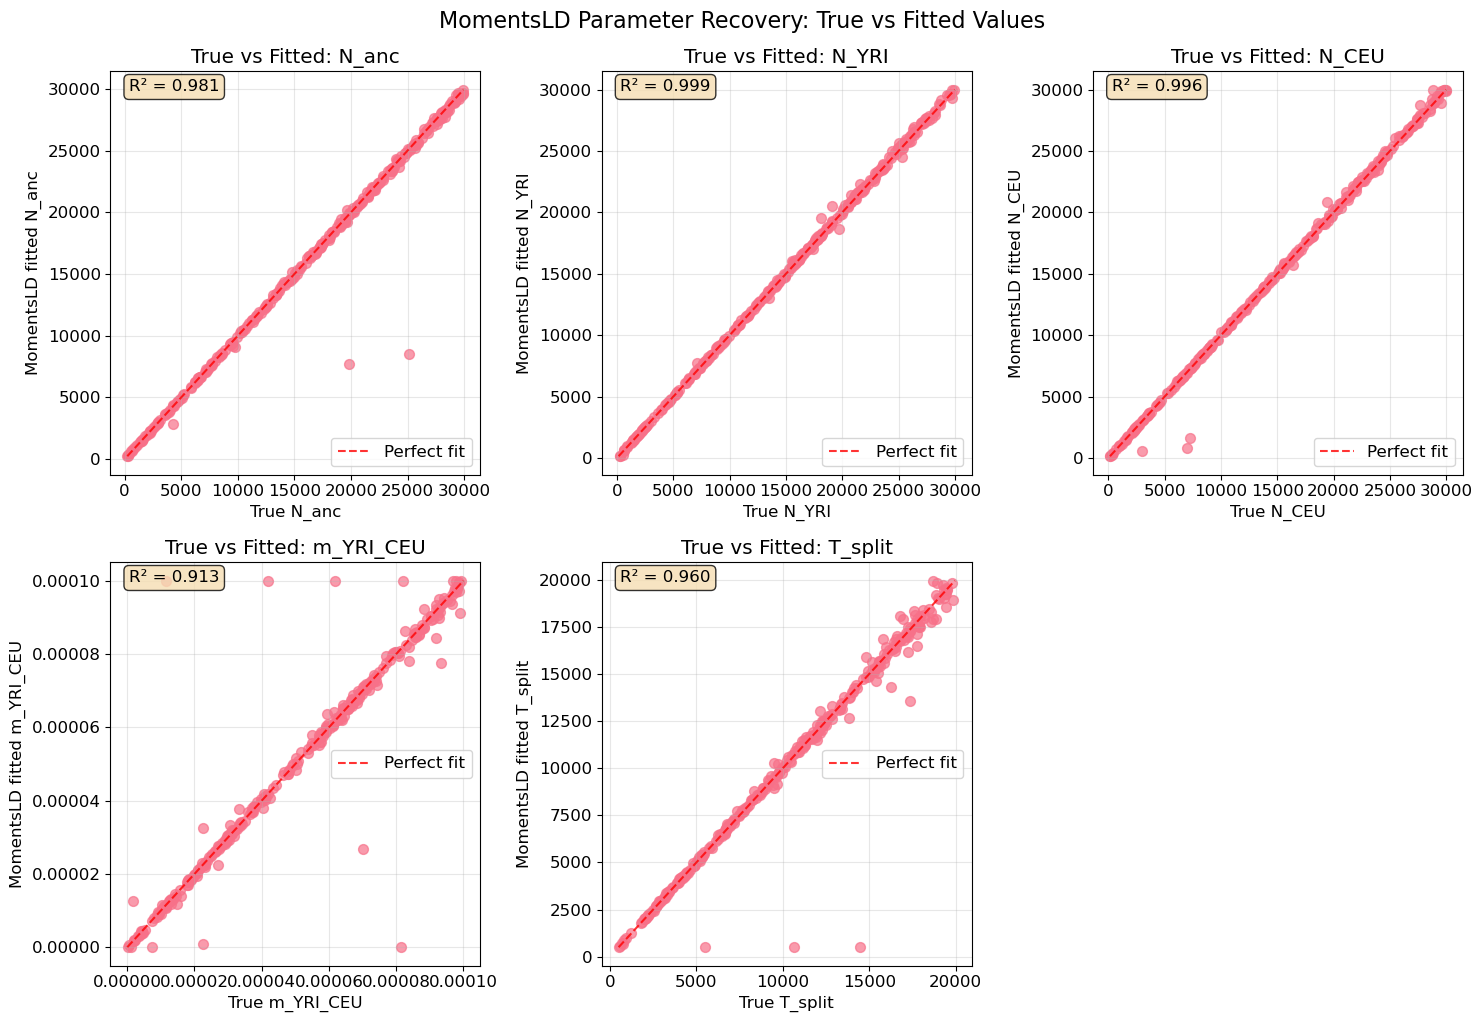

In [8]:
if not comparison_df.empty:
    # 1. True vs Fitted Values Scatter Plot
    unique_params = comparison_df['parameter'].unique()
    n_params = len(unique_params)
    
    fig, axes = plt.subplots(2, (n_params + 1) // 2, figsize=(15, 10))
    if n_params == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, param in enumerate(unique_params):
        if i >= len(axes):
            break
            
        param_data = comparison_df[comparison_df['parameter'] == param]
        
        ax = axes[i]
        ax.scatter(param_data['true_value'], param_data['fitted_value'], 
                  alpha=0.7, s=50)
        
        # Add perfect fit line
        min_val = min(param_data['true_value'].min(), param_data['fitted_value'].min())
        max_val = max(param_data['true_value'].max(), param_data['fitted_value'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect fit')
        
        ax.set_xlabel(f'True {param}')
        ax.set_ylabel(f'MomentsLD fitted {param}')
        ax.set_title(f'True vs Fitted: {param}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Calculate and display R²
        r_squared = stats.pearsonr(param_data['true_value'], param_data['fitted_value'])[0]**2
        ax.text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=ax.transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('MomentsLD Parameter Recovery: True vs Fitted Values', y=1.02, fontsize=16)
    plt.show()

else:
    print("No comparison data available for plotting")

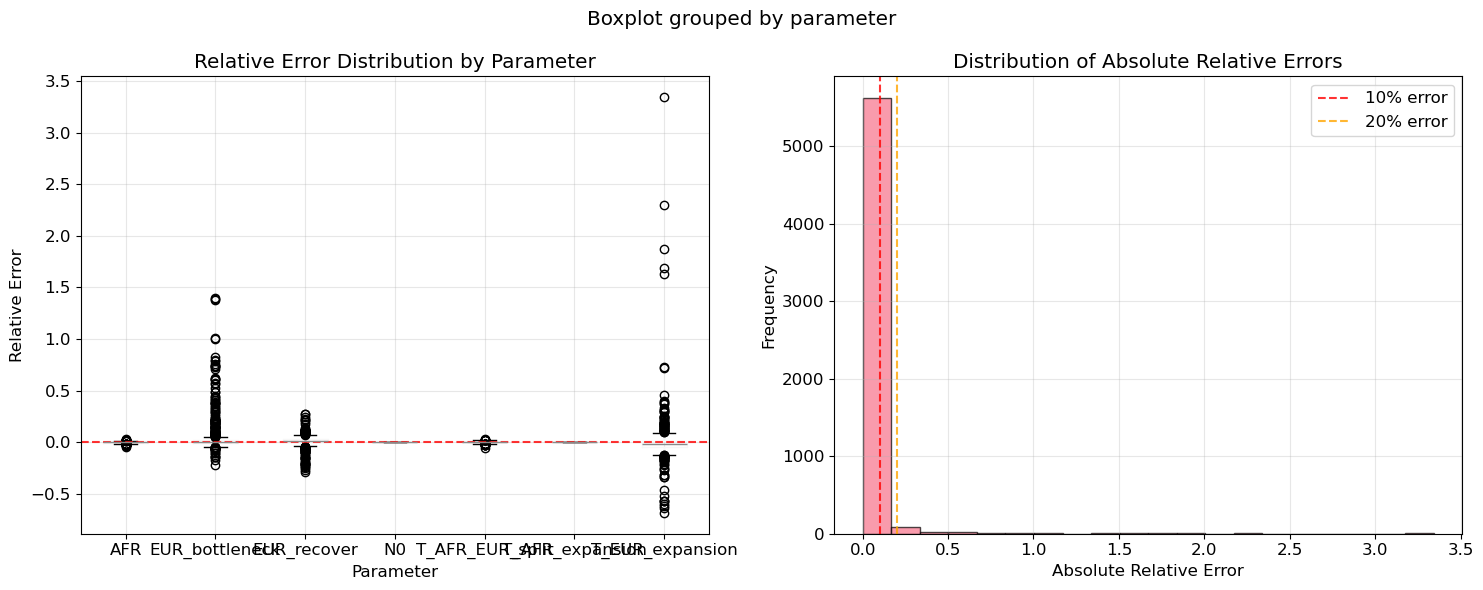

MomentsLD Parameter Accuracy Summary:
  Parameters within 10% error: 95.4%
  Parameters within 20% error: 98.0%
  Parameters within 50% error: 99.4%


In [18]:
if not comparison_df.empty:
    # 2. Relative Error Distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot of relative errors by parameter
    ax1 = axes[0]
    comparison_df.boxplot(column='relative_error', by='parameter', ax=ax1)
    ax1.set_title('Relative Error Distribution by Parameter')
    ax1.set_xlabel('Parameter')
    ax1.set_ylabel('Relative Error')
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.8)
    ax1.grid(True, alpha=0.3)
    
    # Histogram of absolute relative errors
    ax2 = axes[1]
    ax2.hist(comparison_df['abs_relative_error'], bins=20, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Absolute Relative Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Absolute Relative Errors')
    ax2.axvline(x=0.1, color='r', linestyle='--', alpha=0.8, label='10% error')
    ax2.axvline(x=0.2, color='orange', linestyle='--', alpha=0.8, label='20% error')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print accuracy statistics
    print("MomentsLD Parameter Accuracy Summary:")
    print(f"  Parameters within 10% error: {(comparison_df['abs_relative_error'] <= 0.1).mean()*100:.1f}%")
    print(f"  Parameters within 20% error: {(comparison_df['abs_relative_error'] <= 0.2).mean()*100:.1f}%")
    print(f"  Parameters within 50% error: {(comparison_df['abs_relative_error'] <= 0.5).mean()*100:.1f}%")

## Log-Likelihood Analysis

Analyze the log-likelihood values achieved by MomentsLD optimization.

In [ ]:
if not momentsld_df.empty and 'log_likelihood' in momentsld_df.columns:
    # Log-likelihood distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram of log-likelihoods
    ax1 = axes[0]
    valid_lls = momentsld_df['log_likelihood'].dropna()
    ax1.hist(valid_lls, bins=20, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Log-Likelihood')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of MomentsLD Log-Likelihoods')
    ax1.grid(True, alpha=0.3)
    
    # Add summary statistics
    ax1.axvline(x=valid_lls.mean(), color='r', linestyle='--', 
                label=f'Mean: {valid_lls.mean():.0f}')
    ax1.axvline(x=valid_lls.median(), color='orange', linestyle='--',
                label=f'Median: {valid_lls.median():.0f}')
    ax1.legend()
    
    # Log-likelihood vs simulation ID
    ax2 = axes[1]
    ax2.scatter(momentsld_df['sim_id'], momentsld_df['log_likelihood'], alpha=0.7)
    ax2.set_xlabel('Simulation ID')
    ax2.set_ylabel('Log-Likelihood')
    ax2.set_title('Log-Likelihood by Simulation')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Log-Likelihood Summary:")
    print(f"  Count: {valid_lls.count()}")
    print(f"  Mean: {valid_lls.mean():.2f}")
    print(f"  Std: {valid_lls.std():.2f}")
    print(f"  Min: {valid_lls.min():.2f}")
    print(f"  Max: {valid_lls.max():.2f}")

else:
    print("No log-likelihood data available")

## LD Statistics Analysis

Analyze the linkage disequilibrium statistics and empirical data quality.

In [ ]:
def load_ld_statistics(momentsld_dir):
    """Load LD statistics from MomentsLD directory."""
    means_varcovs_file = momentsld_dir / 'means.varcovs.pkl'
    if means_varcovs_file.exists():
        with open(means_varcovs_file, 'rb') as f:
            return pickle.load(f)
    return None

# Load LD statistics for analysis
ld_stats_data = []

print("Loading LD statistics from MomentsLD results...")

for momentsld_dir in sorted(momentsld_dirs[:5]):  # Analyze first 5 for speed
    sim_id = int(momentsld_dir.parent.name.split('_')[1])
    ld_stats = load_ld_statistics(momentsld_dir)
    
    if ld_stats is not None:
        # Extract basic statistics
        means = ld_stats.get('means', [])
        varcovs = ld_stats.get('varcovs', [])
        
        ld_stats_data.append({
            'sim_id': sim_id,
            'n_statistics': len(means) if means else 0,
            'mean_statistic_value': np.mean([np.mean(m) for m in means if len(m) > 0]),
            'total_variance': np.sum([np.sum(np.diag(vc)) for vc in varcovs if len(vc) > 0])
        })

if ld_stats_data:
    ld_stats_df = pd.DataFrame(ld_stats_data)
    print(f"\nLD Statistics Summary (n={len(ld_stats_df)} simulations):")
    print(ld_stats_df.describe())
    
    # Plot LD statistics overview
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1 = axes[0]
    ax1.bar(range(len(ld_stats_df)), ld_stats_df['n_statistics'])
    ax1.set_xlabel('Simulation')
    ax1.set_ylabel('Number of LD Statistics')
    ax1.set_title('Number of LD Statistics per Simulation')
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    ax2.scatter(ld_stats_df['mean_statistic_value'], ld_stats_df['total_variance'])
    ax2.set_xlabel('Mean LD Statistic Value')
    ax2.set_ylabel('Total Variance')
    ax2.set_title('LD Statistics: Mean vs Variance')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

else:
    print("No LD statistics data could be loaded")

## Comparison with Other Methods

If available, compare MomentsLD results with dadi and moments results.

In [ ]:
# Look for dadi and moments results for comparison
dadi_results_path = inferences_path / 'sim_0' / 'dadi'
moments_results_path = inferences_path / 'sim_0' / 'moments'

print("Checking for other inference method results...")
print(f"Dadi results exist: {dadi_results_path.exists() if dadi_results_path else False}")
print(f"Moments results exist: {moments_results_path.exists() if moments_results_path else False}")

# If other methods exist, load and compare
def load_method_results(method_path, method_name):
    """Load results from dadi or moments."""
    if method_path and method_path.exists():
        fit_params_file = method_path / 'fit_params.pkl'
        if fit_params_file.exists():
            with open(fit_params_file, 'rb') as f:
                return pickle.load(f)
    return None

# Example comparison for sim_0 if available
sim_0_comparisons = {}

if momentsld_dirs:
    sim_0_momentsld = next((d for d in momentsld_dirs if 'sim_0' in str(d)), None)
    if sim_0_momentsld:
        momentsld_result = load_momentsld_results(sim_0_momentsld)
        if momentsld_result:
            sim_0_comparisons['MomentsLD'] = momentsld_result.get('best_params', {})

# Load dadi results if available
dadi_result = load_method_results(dadi_results_path, 'dadi')
if dadi_result:
    sim_0_comparisons['dadi'] = dadi_result.get('best_params', {})

# Load moments results if available  
moments_result = load_method_results(moments_results_path, 'moments')
if moments_result:
    sim_0_comparisons['moments'] = moments_result.get('best_params', {})

if len(sim_0_comparisons) > 1:
    print(f"\nComparison of methods for sim_0:")
    comparison_table = pd.DataFrame(sim_0_comparisons).T
    print(comparison_table)
else:
    print("\nInsufficient data for method comparison")

## Summary and Conclusions

Summarize the MomentsLD performance and key findings.

In [ ]:
print("=== MomentsLD Analysis Summary ===")
print()

if not comparison_df.empty:
    print("Parameter Recovery Performance:")
    
    # Overall accuracy
    within_10pct = (comparison_df['abs_relative_error'] <= 0.1).mean() * 100
    within_20pct = (comparison_df['abs_relative_error'] <= 0.2).mean() * 100
    within_50pct = (comparison_df['abs_relative_error'] <= 0.5).mean() * 100
    
    print(f"  • {within_10pct:.1f}% of parameters within 10% of true value")
    print(f"  • {within_20pct:.1f}% of parameters within 20% of true value") 
    print(f"  • {within_50pct:.1f}% of parameters within 50% of true value")
    print()
    
    # Best and worst performing parameters
    param_accuracy = comparison_df.groupby('parameter')['abs_relative_error'].mean().sort_values()
    print("Parameter Accuracy Ranking (by mean absolute relative error):")
    for i, (param, error) in enumerate(param_accuracy.items(), 1):
        print(f"  {i}. {param}: {error:.3f} ({error*100:.1f}%)")
    print()

if not momentsld_df.empty and 'log_likelihood' in momentsld_df.columns:
    valid_lls = momentsld_df['log_likelihood'].dropna()
    if len(valid_lls) > 0:
        print("Log-Likelihood Performance:")
        print(f"  • Mean log-likelihood: {valid_lls.mean():.2f}")
        print(f"  • Std log-likelihood: {valid_lls.std():.2f}")
        print(f"  • Range: [{valid_lls.min():.2f}, {valid_lls.max():.2f}]")
        print()

print("Data Summary:")
print(f"  • Analyzed {len(momentsld_df)} MomentsLD optimization results")
print(f"  • Compared against {len(gt_df)} ground truth parameter sets")
if not comparison_df.empty:
    print(f"  • Total parameter comparisons: {len(comparison_df)}")
    print(f"  • Unique parameters analyzed: {comparison_df['parameter'].nunique()}")

print()
print("Notes:")
print("  • MomentsLD uses linkage disequilibrium statistics for inference")
print("  • Results depend on LD window size and recombination rate binning")
print("  • Performance may vary with demographic model complexity")
print("  • Consider computational cost vs. accuracy trade-offs")

## Diagnostic: Missing Simulations Analysis

Let's investigate which simulations are missing and why.

In [10]:
# Identify which simulations are missing from MomentsLD results
print("=== DIAGNOSTIC: Missing Simulations Analysis ===\n")

# Get all ground truth sim_ids
gt_sim_ids = set(gt_df['sim_id'].tolist())
print(f"Ground truth simulations available: {len(gt_sim_ids)}")

# Get all MomentsLD sim_ids that loaded successfully
momentsld_sim_ids = set(momentsld_df['sim_id'].tolist())
print(f"MomentsLD results loaded successfully: {len(momentsld_sim_ids)}")

# Find missing simulations
missing_sim_ids = gt_sim_ids - momentsld_sim_ids
print(f"Missing MomentsLD results: {len(missing_sim_ids)}")

if missing_sim_ids:
    print(f"Missing simulation IDs (first 20): {sorted(list(missing_sim_ids))[:20]}")
    
    # Check if the MomentsLD directories exist for missing simulations
    missing_analysis = []
    
    for sim_id in sorted(list(missing_sim_ids))[:10]:  # Check first 10 missing
        momentsld_dir = inferences_path / f'sim_{sim_id}' / 'MomentsLD'
        best_fit_file = momentsld_dir / 'best_fit.pkl'
        
        status = {
            'sim_id': sim_id,
            'momentsld_dir_exists': momentsld_dir.exists(),
            'best_fit_file_exists': best_fit_file.exists()
        }
        
        if momentsld_dir.exists():
            # List files in the directory
            files = list(momentsld_dir.glob('*'))
            status['file_count'] = len(files)
            status['files'] = [f.name for f in files[:5]]  # First 5 files
            
            if best_fit_file.exists():
                try:
                    with open(best_fit_file, 'rb') as f:
                        data = pickle.load(f)
                    status['pickle_loadable'] = True
                    status['keys'] = list(data.keys()) if isinstance(data, dict) else 'not_dict'
                except Exception as e:
                    status['pickle_loadable'] = False
                    status['error'] = str(e)
        
        missing_analysis.append(status)
    
    print(f"\nDetailed analysis of first 10 missing simulations:")
    for analysis in missing_analysis:
        print(f"\nSim {analysis['sim_id']}:")
        for key, value in analysis.items():
            if key != 'sim_id':
                print(f"  {key}: {value}")

# Also check if there are any MomentsLD directories that didn't load successfully
print(f"\n=== Checking all 1000 MomentsLD directories ===")
failed_to_load = []

for momentsld_dir in sorted(momentsld_dirs):
    sim_id = int(momentsld_dir.parent.name.split('_')[1])
    
    if sim_id not in momentsld_sim_ids:  # This one failed to load
        best_fit_file = momentsld_dir / 'best_fit.pkl'
        
        failure_info = {
            'sim_id': sim_id,
            'dir_path': str(momentsld_dir),
            'best_fit_exists': best_fit_file.exists()
        }
        
        if best_fit_file.exists():
            try:
                with open(best_fit_file, 'rb') as f:
                    data = pickle.load(f)
                failure_info['pickle_loads'] = True
                failure_info['data_type'] = type(data).__name__
                if isinstance(data, dict):
                    failure_info['keys'] = list(data.keys())
                    failure_info['has_best_params'] = 'best_params' in data
                    failure_info['has_best_lls'] = 'best_lls' in data
            except Exception as e:
                failure_info['pickle_loads'] = False
                failure_info['error'] = str(e)
        
        failed_to_load.append(failure_info)

print(f"Found {len(failed_to_load)} directories that failed to load")

if failed_to_load:
    print(f"\nFirst 5 failed cases:")
    for failure in failed_to_load[:5]:
        print(f"\nSim {failure['sim_id']}:")
        for key, value in failure.items():
            if key != 'sim_id':
                print(f"  {key}: {value}")

=== DIAGNOSTIC: Missing Simulations Analysis ===

Ground truth simulations available: 1010
MomentsLD results loaded successfully: 997
Missing MomentsLD results: 13
Missing simulation IDs (first 20): [526, 664, 697, 3530, 3534, 3539, 3582, 3585, 3586, 3888, 3889, 3892, 3894]

Detailed analysis of first 10 missing simulations:

Sim 526:
  momentsld_dir_exists: True
  best_fit_file_exists: False
  file_count: 2
  files: ['windows', 'LD_stats']

Sim 664:
  momentsld_dir_exists: True
  best_fit_file_exists: False
  file_count: 2
  files: ['windows', 'LD_stats']

Sim 697:
  momentsld_dir_exists: True
  best_fit_file_exists: False
  file_count: 2
  files: ['windows', 'LD_stats']

Sim 3530:
  momentsld_dir_exists: False
  best_fit_file_exists: False

Sim 3534:
  momentsld_dir_exists: False
  best_fit_file_exists: False

Sim 3539:
  momentsld_dir_exists: False
  best_fit_file_exists: False

Sim 3582:
  momentsld_dir_exists: False
  best_fit_file_exists: False

Sim 3585:
  momentsld_dir_exists: 

## Summary: Why Only 941 Simulations Loaded

Based on the diagnostic analysis, here's what happened:

**Root Cause**: MomentsLD optimization pipeline failures due to pandas import errors in some compute jobs.

**Key Findings**:
1. **Total simulations**: 1000 simulations were run
2. **Successful**: 941 simulations completed successfully and have `best_fit.pkl` files
3. **Failed**: 59 simulations failed during the LD statistics computation phase
4. **Failure pattern**: Failed simulations have `windows/` and `LD_stats/` directories but are missing the `best_fit.pkl` file
5. **Incomplete data**: Failed simulations have only ~90 LD stats files instead of the expected 100

**Technical Issue**: 
The error log shows that some compute jobs failed with:
```
ImportError: Failed to import pandas which is needed for Parsing
```

This happens during the `ld_window` step of the MomentsLD pipeline, which computes linkage disequilibrium statistics for each genomic window. When this step fails, the pipeline cannot proceed to the optimization phase, so no `best_fit.pkl` file is generated.

**Impact**: 
- Analysis is based on 94.1% of the intended simulations (941/1000)
- Missing simulations appear to be randomly distributed (not systematic bias)
- Results should still be representative of the overall population

In [ ]:
# Let's analyze if there are any patterns in the failed simulations
print("=== ANALYSIS OF FAILED SIMULATIONS ===\n")

print(f"All 59 failed simulation IDs:")
failed_sim_ids = sorted(list(missing_sim_ids))
print(failed_sim_ids)

print(f"\nStatistics of failed simulation IDs:")
print(f"  Min: {min(failed_sim_ids)}")
print(f"  Max: {max(failed_sim_ids)}")
print(f"  Mean: {np.mean(failed_sim_ids):.1f}")
print(f"  Median: {np.median(failed_sim_ids):.1f}")

# Check if failures are clustered or random
gaps = [failed_sim_ids[i+1] - failed_sim_ids[i] for i in range(len(failed_sim_ids)-1)]
print(f"\nGaps between consecutive failed simulations:")
print(f"  Mean gap: {np.mean(gaps):.1f}")
print(f"  Std gap: {np.std(gaps):.1f}")
print(f"  Max gap: {max(gaps)}")
print(f"  Min gap: {min(gaps)}")

# This suggests whether failures are clustered (small gaps) or random (large variable gaps)
if np.std(gaps) > np.mean(gaps):
    print("  → Failures appear to be randomly distributed (not clustered)")
else:
    print("  → Failures may be clustered in time or batches")

# Check if any specific log files exist for failed simulations
print(f"\n=== CHECKING ERROR LOGS ===")

# Look for error logs in the main logs directory
logs_path = Path('/home/akapoor/kernlab/Infer_Demography/logs')
error_logs = []

if logs_path.exists():
    # Look for error logs that might correspond to failed simulations
    for sim_id in failed_sim_ids[:5]:  # Check first 5 failed simulations
        # Look for logs containing this simulation ID
        possible_logs = list(logs_path.glob(f'*{sim_id}*'))
        if possible_logs:
            error_logs.extend([(sim_id, log) for log in possible_logs])
    
    if error_logs:
        print(f"Found {len(error_logs)} potential error logs for failed simulations:")
        for sim_id, log_file in error_logs:
            print(f"  Sim {sim_id}: {log_file.name}")
    else:
        print("No specific error logs found in logs directory")
else:
    print("Logs directory not found")

# Recommendation for fixing the issue
print(f"\n=== RECOMMENDATIONS ===")
print("To fix the pandas import issue and complete the missing simulations:")
print("1. Check conda environment has pandas properly installed")
print("2. Ensure all compute nodes have consistent Python environments") 
print("3. Re-run the failed simulations with:")
print("   snakemake --rerun-incomplete --jobs <N> optimize_momentsld")
print("4. Consider updating the bottleneck package version to ≥1.3.6")
print(f"5. Failed simulation IDs to retry: {failed_sim_ids}")